# Tumor Classification Project

### Description:

The purpose of this project is the employ computer vision and a CNN in order to classify MRI images of brains with and without tumors. The primary purpose is to train the model on a binary classifier (tumor or no tumor), then secondarily to classify the type of tumor if one is present.

### Dataset:
https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

The data set provides the MRI images in their own folders of either 'yes' or 'no' (referring to if the scan contains a tumor). There are 154 images in the yes folder (tumor) and 91 in the no folder (healthy).

### Importing Packages

In [ ]:
#Importing primary packages
import numpy as np
import torch
import glob
import cv2

#Importing Dependencies
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

Matplotlib is building the font cache; this may take a moment.


### Data Reading

In [ ]:
#First creating empty lists
tumor = []
healthy = []

#Then iterating over all images and appending them to the empty lists
for f in glob.iglob('C:/Data/brain_tumor_dataset/yes/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    tumor.append(img)

for f in glob.iglob('C:/Data/brain_tumor_dataset/no/*.jpg'):
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [ ]:
#Verifying all the previous steps worked properly; we should see 154 images, sized to 128x128 dimensions and 3 different channels for rgb values.
tumor.shape

In [14]:
#Making the lists into arrays that can be processed by the ML model
healthy = np.array(healthy)
tumor = np.array(tumor)

#Combining the two datasets so we can randomize, split, and feed to the model.
All = np.concatenate((healthy,tumor))

In [15]:
#Checking that our concatenation was done properly
All.shape

(245, 128, 128, 3)

### EDA
Before further altering the data and creating the model, I'm going to do a little EDA to understand the data.

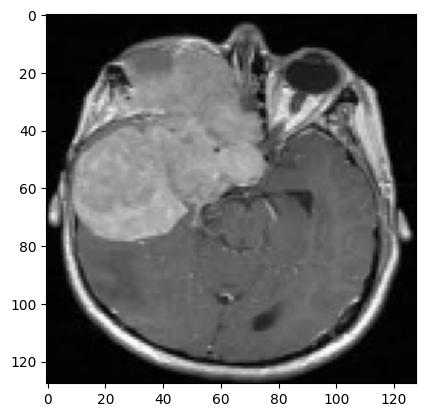

In [ ]:
#Opening one of the images
plt.imshow(tumor[8])

### Creating The Model

*Note*: This is something that I think I need to improve upon, PyTorch now has functions that are able to load in the data, so I want to see if there is a better way to load in the data without having to make these classes. ALSO, the data loading that I can notice is wants to directly take in the training, test, and validation sets (which I would need to produce myself).

In [3]:
class Dataset(object):
    """
        Default pytorch abstract dataset class
    """

    def __getitem__(self,index):
        raise NotImplementedError
    
    def __len__(self):
        raise NotImplementedError
    
    def __add__(self, other):
        return ConcatDataset([self, other])

In [4]:
class MRI(Dataset):
    """

    """
    def __init__(self):
        tumor = []
        healthy = []

        #Then iterating over all images and appending them to the empty lists
        for f in glob.iglob('C:/Data/brain_tumor_dataset/yes/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            tumor.append(img)

        for f in glob.iglob('C:/Data/brain_tumor_dataset/no/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img, (128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            healthy.append(img)

        #Creating arrays from the images
        healthy = np.array(healthy)
        tumor = np.array(tumor)

        #Creating the labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        #Concatenating the data
        self.images = np.concatenate((tumor,healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))


    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample